# Video classification and feature extraction using the Inflated 3D Convnet  (I3D)

Welcome! In this lab, you'll learn how to use a pre-trained network for classifying a short video into an action class and for extracting features for future use. The goal of video classification is to predict one action label for a short video. 

The architecture we will use is the [Inflated 3D Convnet (I3D)](https://github.com/deepmind/kinetics-i3d) recently proposed by Carreira and Zisserman[1]. We will use the pretrained models provided by the authors, which are Inception-v1 I3D models trained on the Kinetics dataset training split. In their paper, they reported state-of-the-art results on the UCF101 and HMDB51 datasets from fine-tuning these models. I3D models pre-trained on Kinetics also placed first in the CVPR 2017 Charades challenge. 

We will emphasize three main differences of this architecture (and in general video classification architectures) from image classification deep learning architectures: 
- our main input is a video, i.e. a sequence of RGB images (frames)
- a complementary input consists of a sequence of optical flow images, capturing motion. Deep learning  architectures utilizing both types of inputs (RGB frames and optical flow frames) are referred to as two-stream architectures.
- convolutional filters are 3D, operating in space and time.


This notebook builds upon the [demo script](https://github.com/deepmind/kinetics-i3d/blob/master/evaluate_sample.py) provided by the authors.

[1] Carreira, Joao, and Andrew Zisserman. "Quo vadis, action recognition? a new model and the kinetics dataset." 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). IEEE, 2017.

In [1]:
# Uncomment for google collaboratory
# !git clone https://github.com/emavroudi/jsalt18-actrec-lab
# !pip install dm-sonnet
# import os
# os.chdir('./jsalt18-actrec-lab/notebooks')
# !pwd
# import sys
# sys.path.append('/content/jsalt18-actrec-lab')

# Import libraries

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pdb

from IPython.display import Image
from IPython.display import display

import kinetics_i3d.i3d as i3d

/cis/home/efi/work/ar_libs/anaconda3/envs/action_detection_tf1.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Input data paths, model paths and other options

We will use the preprocessed sequence of RGB frames and optical flow frames of this sample video, as they are provided by the authors. The same preprocessing was applied to the videos that were used to train the model we will be using. Preprocessing steps include computing optical flow (see https://docs.opencv.org/3.3.0/dc/d47/classcv_1_1DualTVL1OpticalFlow.html), resizing rgb and flow frames, selecting the center 224x224 image crop and normalizing pixel values.

In [3]:
# For RGB, the videos are resized preserving aspect ratio so that the smallest dimension is 256 pixels,
# with bilinear interpolation. 
_IMAGE_SIZE = 224

# Number of action classes of the kinetics dataset
_NUM_CLASSES = 400

# Number of frames of the sample video
_SAMPLE_VIDEO_FRAMES = 79

# After resizing RGB videos, pixel values are then rescaled between -1 and 1. 
# While during test, we select the center 224x224 image crop from the video. A sample preprocessed
# video is provided in ./kinetics_i3d/data/v_CricketShot_g04_c01_rgb.npy
#
# For the Flow stream, after sampling the videos at 25 frames per second, 
# we convert the videos to grayscale. We apply a TV-L1 optical flow algorithm. 
# Pixel values are truncated to the range [-20, 20], then rescaled between -1 and 1. 
# We only use the first two output dimensions, and apply the same cropping as for RGB. 
# The provided .npy file thus has shape (1, num_frames, 224, 224, 2) for Flow,
# corresponding to a batch size of 1.
_SAMPLE_PATHS = {
    'rgb': '../kinetics_i3d/data/v_CricketShot_g04_c01_rgb.npy',
    'flow': '../kinetics_i3d/data/v_CricketShot_g04_c01_flow.npy',
}

# Paths of models pretrained on imagenet and on Kinetics
_CHECKPOINT_PATHS = {
    'rgb': '../kinetics_i3d/data/checkpoints/rgb_scratch/model.ckpt',
    'flow': '../kinetics_i3d/data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': '../kinetics_i3d/data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': '../kinetics_i3d/data/checkpoints/flow_imagenet/model.ckpt',
}

# File with action names of the Kinetics dataset (400 action classes)
_LABEL_MAP_PATH = '../kinetics_i3d/data/label_map.txt'

FLAGS = tf.flags.FLAGS

# =============================================================
# User defined options.

# Option to use only rgb stream (appearance), only optical flow stream (motion) or both.
# Default option: use both.
tf.flags.DEFINE_string('eval_type', 'joint', 'rgb, flow, or joint')
# The default model has been pre-trained on ImageNet and then Kinetics.
tf.flags.DEFINE_boolean('imagenet_pretrained', True, '')
# Option to extract features from a specific endpoint of the network.
# Default option: Mixed_5c.
tf.flags.DEFINE_string('feat_endpoint', 'Mixed_5c', 'Mixed_4e or Mixed_4f or Mixed_5c')
# Option to extract features from rgb or optical flow.
# Default option: rgb.
tf.flags.DEFINE_string('feat_stream', 'flow', 'rgb or flow')
tf.app.flags.DEFINE_string('f', '', 'kernel')

# Check user defined parameters
tf.logging.set_verbosity(tf.logging.INFO)
eval_type = FLAGS.eval_type
feat_endpoint = FLAGS.feat_endpoint
feat_stream = FLAGS.feat_stream
imagenet_pretrained = FLAGS.imagenet_pretrained

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')
if feat_endpoint not in ['Mixed_4e', 'Mixed_4f', 'Mixed_5c']:
    raise ValueError('Bad `feat_endpoint`, must be one of Mixed_4f, Mixed_5c')
if feat_stream not in ['rgb', 'flow']:
    raise ValueError('Bad `feat_stream`, must be one of rgb, flow')

# Kinetics action classes

The [Kinetics dataset](https://deepmind.com/research/open-source/open-source-datasets/kinetics/) provides 240K videos from 400 action classes. This dataset was used to train the I3D models used in this tutorial.

In [4]:
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
print(kinetics_classes)

['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer', 'auctioning', 'baby waking up', 'baking cookies', 'balloon blowing', 'bandaging', 'barbequing', 'bartending', 'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing', 'bending back', 'bending metal', 'biking through snow', 'blasting sand', 'blowing glass', 'blowing leaves', 'blowing nose', 'blowing out candles', 'bobsledding', 'bookbinding', 'bouncing on trampoline', 'bowling', 'braiding hair', 'breading or breadcrumbing', 'breakdancing', 'brush painting', 'brushing hair', 'brushing teeth', 'building cabinet', 'building shed', 'bungee jumping', 'busking', 'canoeing or kayaking', 'capoeira', 'carrying baby', 'cartwheeling', 'carving pumpkin', 'catching fish', 'catching or throwing baseball', 'catching or throwing frisbee', 'catching or throwing softball', 'celebrating', 'changing oil', 'changing wheel', 'checking tires', 'che

# Sample input video  (RGB and Optical Flow)

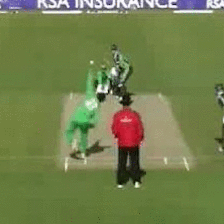

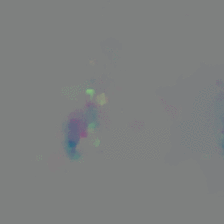

In [5]:
with open('../kinetics_i3d/data/v_CricketShot_g04_c01_rgb.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))
with open('../kinetics_i3d/data/v_CricketShot_g04_c01_flow.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))

(1, 79, 224, 224, 2)


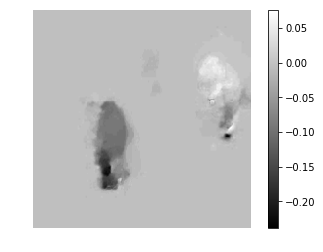

In [16]:
flow_sample = np.load(_SAMPLE_PATHS['flow'])
print(flow_sample.shape)
# Show horizontal optical flow component
frame_ind = 60
plt.imshow(np.squeeze(flow_sample[:, frame_ind, :, :, 0]), cmap='gray')
plt.axis('off')
plt.colorbar()

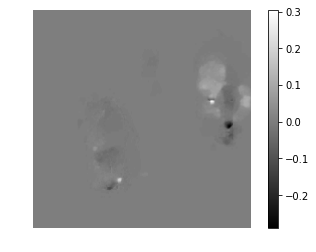

In [17]:
# # Show vertical optical flow component
plt.imshow(np.squeeze(flow_sample[:, frame_ind, :, :, 1]), cmap='gray')
plt.axis('off')
plt.colorbar()

# Inception-V1 I3D Model Architecture (see ../kinetics_i3d/i3d.py)

The I3D architecture is based on the Inception-V1[2] architecture proposed for image classification. In order to capture local temporal information, the originally 2D convolutional filters are "inflated" to 3D (e.g. a 7x7 convolution is replaced by a 7x7x7 convolution).

![Original Inception V1 architecture for 2D image classification](http://joelouismarino.github.io/images/blog_images/blog_googlenet_keras/googlenet_diagram.png)

[2] Szegedy, Christian, et al. "Going Deeper With Convolutions."  2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). IEEE, 2015.

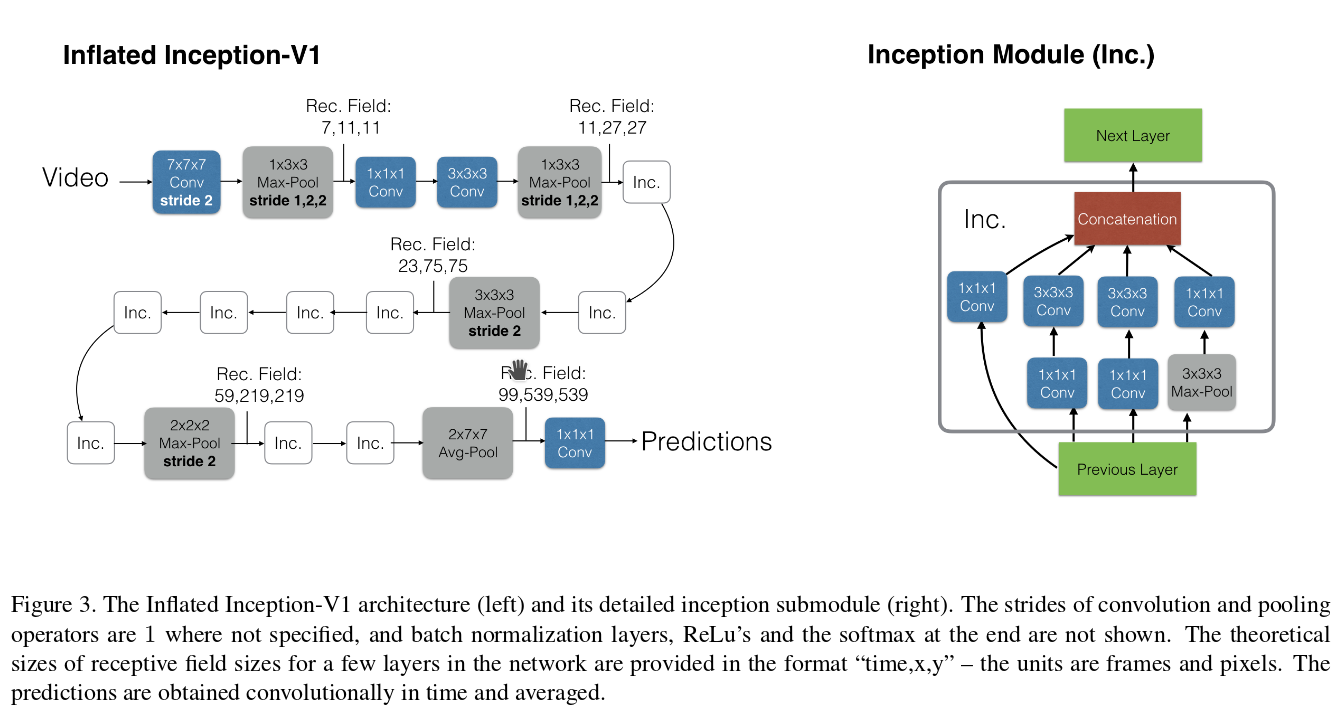

In [8]:
Image(filename='../kinetics_i3d/data/i3d_architecture.png') 

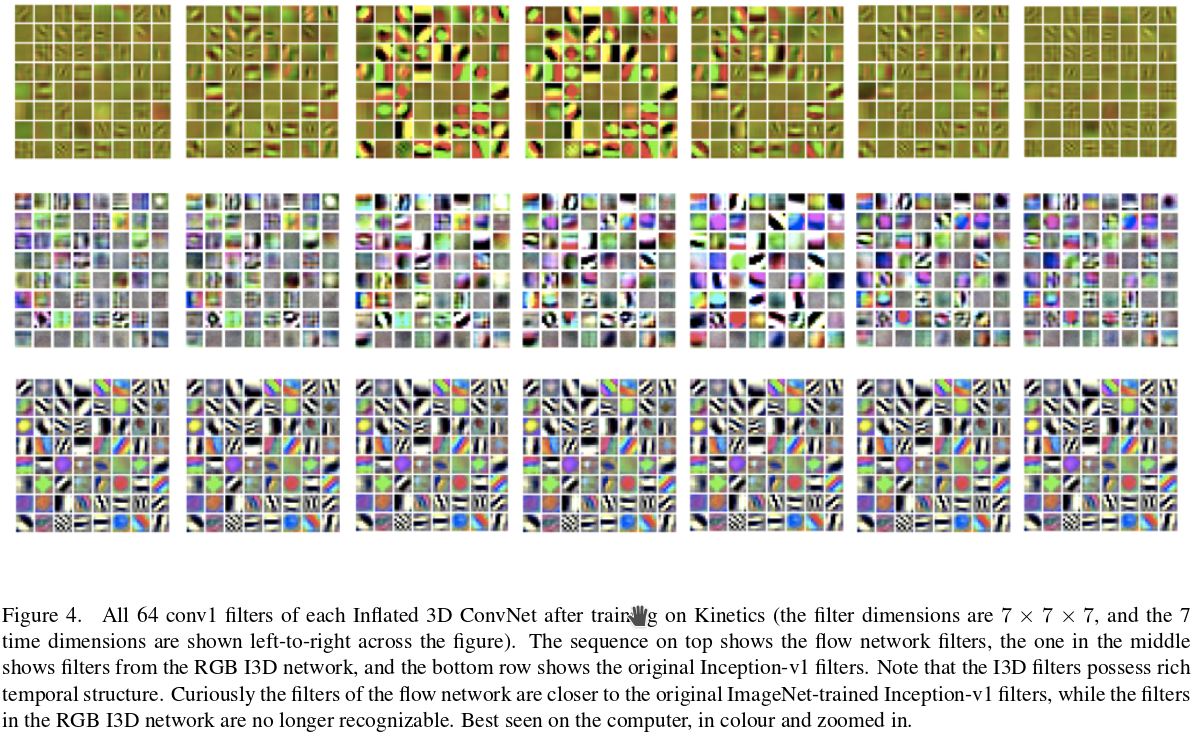

In [9]:
Image(filename='../kinetics_i3d/data/i3d_filters.png') 

# RGB stream model

Define tensorflow graph for getting action scores and intermediate feature maps given a sequence of RGB frames. Variables will be later restored from pre-trained models.

In [10]:
if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        # Final endpoint determines the op returned by rgb model. 
        # Logits: scores per action class before softmax
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        # Get scores for each class given the rgb input
        # Also get intermediate feature maps (endpoints)
        rgb_logits, rgb_endpoints = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
        
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

# Flow stream model

Define tensorflow graph for getting action scores and intermediate feature maps given optical flow frames. Note that the graph is identical to the rgb model, except for the number of input channels (2 channels for horizontal and vertical flow vs 3 channels for R(ed), G(reen), B(lue) channels). Variables will be later restored from pre-trained models.

In [11]:
if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels. (flow_x, flow_y)
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        # Build graph for getting action class scores and intermediate feature maps.
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        # Get scores for each class given optical flow input
        # Also get intermediate feature maps (endpoints)
        flow_logits, flow_endpoints = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
        
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

# Fuse per action scores from RGB (appearance) and Flow (motion) streams and apply softmax

We have now built two graphs, one for getting action class scores from RGB frames and one for getting action class scores from optical flow frames. We can either use these scores separately or fuse their predictions, e.g. by summing them. Combining the action class scores from the two networks allows us to take advantage of the two complementary input streams.

In [12]:
if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

# Features from specified endpoint

Get model graph until the desired endpoint (layer of the network), from which we will get a feature map of a size $(T^{\prime}, W^{\prime}, H^{\prime}, C^{\prime})$.

In [13]:
if feat_stream == 'rgb':
    features = rgb_endpoints[feat_endpoint]
elif feat_stream == 'flow':
    features = flow_endpoints[feat_endpoint]

# Predict an action label for the input video sample by running a forward pass through the networks

In [14]:
with tf.Session() as sess:
    feed_dict = {}
    
    # Restore weights from models pretrained on rgb frames.
    # Also, load rgb frames of sample video.
    if eval_type in ['rgb', 'joint']:
        if imagenet_pretrained:
            rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        else:
            rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
        tf.logging.info('RGB checkpoint restored')
        rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
        tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
        feed_dict[rgb_input] = rgb_sample

    # Restore weights from models pretrained on optical flow frames.
    # Also, load optical flow frames of sample video.
    if eval_type in ['flow', 'joint']:
        if imagenet_pretrained:
            flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        else:
            flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
        tf.logging.info('Flow checkpoint restored')
        flow_sample = np.load(_SAMPLE_PATHS['flow'])
        tf.logging.info('Flow data loaded, shape=%s',
                        str(flow_sample.shape))
        feed_dict[flow_input] = flow_sample

    # Forward pass through the network
    # Note that whether we pass data through 
    # the rgb or the flow model or both
    # depends on the hyperparameter: eval_type
    out_logits, out_predictions, out_features = sess.run(
        [model_logits, model_predictions, features],
        feed_dict=feed_dict)

    out_logits = out_logits[0]
    out_predictions = out_predictions[0]
    sorted_indices = np.argsort(out_predictions)[::-1]

    print('Norm of logits: %f' % np.linalg.norm(out_logits))
    print('\nTop classes and probabilities')
    for index in sorted_indices[:20]:
        print(out_predictions[index], out_logits[index],
              kinetics_classes[index])

INFO:tensorflow:Restoring parameters from ../kinetics_i3d/data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from ../kinetics_i3d/data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468689

Top classes and probabilities
1.0 41.813683 playing cricket
1.4971592e-09 21.493986 hurling (sport)
3.8430797e-10 20.134106 catching or throwing baseball
1.5492183e-10 19.225582 catching or throwing softball
1.1360122e-10 18.915356 hitting baseball
8.8011216e-11 18.660126 playing tennis
2.4415466e-11 17.377878 playing kickball
1.1532015e-11 16.627789 playing squash or racquetball
6.131901e-12 15.996166 shooting goal (soccer)
4.391744e-12 15.662387 hammer throw
2.2134141e-12 14.977198 golf putting
1.6307001e-12 14.671671 throwing discus
1.5456072e-12 14.618078 javel

# Extract feature vector

Given the feature map we have obtained at the desired endpoint (layer) of the network, we will apply 
pooling to obtain a feature vector for the sample video. We can extract a feature vector from the rgb stream and another feature vector from the optical flow stream.

In [15]:
# Mixed 4e: (t, 14, 14, 528), after average pooling: feat_dim: 528
# Mixed 4f: (t, 14, 14, 832), after average pooling: feat_dim: 832
# Mixed 5c, right after the last inception module block: shape: (t, 7, 7, 1024).
#           After applying spatio-temporal average pooling: feat_dim: 1024.

print('Feature map shape before pooling: (temporal_dim, x_dim, y_dim, feat_dim): {}'.format(str(out_features[0].shape)))
# Average pooling
feat = np.mean(out_features[0], axis=(0,1,2))
print('Feature vector size: {}'.format(str(feat.shape)))

Feature map shape before pooling: (temporal_dim, x_dim, y_dim, feat_dim): (10, 7, 7, 1024)
Feature vector size: (1024,)


# Additional resources:
- Pytorch implementation, also provides code for finetuning: https://github.com/piergiaj/pytorch-i3d
- OpenCV Library: https://opencv.org/ for [optical flow computation](https://stackoverflow.com/questions/37871443/how-to-compute-optical-flow-using-tvl1-opencv-function), [video I/O](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html), [image transformations](https://docs.opencv.org/3.4.0/da/d6e/tutorial_py_geometric_transformations.html) etc.
- https://github.com/feichtenhofer/gpu_flow
